In [1]:
import numpy as np             
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from keras.applications.resnet import ResNet50
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:

Resnet_model = ResNet50(weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [3]:
result = Resnet_model.output
result = GlobalAveragePooling2D()(result)
# add a fully-connected layer
result = Dense(512, activation='relu')(result)
# and a fully connected output/classification layer
predictions = Dense(2, activation='sigmoid')(result)

In [4]:
inception_transfer =Model(inputs=Resnet_model.input, outputs=predictions)

In [5]:
from tensorflow.keras.optimizers import SGD
inception_transfer.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [7]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_path = 'C:/Users/Computing/Downloads/data-task1/train'
test_path = 'C:/Users/Computing/Downloads/data-task1/test'
valid_path = 'C:/Users/Computing/Downloads/data-task1/val'

test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')

Found 3000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
with tf.device("/device:GPU:0"):
    history_pretrained = inception_transfer.fit_generator(
    train_generator,
    epochs=15, shuffle = True, verbose = 1, validation_data = test_generator)

C:\Users\Computing\AppData\Local\Temp\ipykernel_7436\20635616.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_pretrained = inception_transfer.fit_generator(


Epoch 1/15
188/188 [==============================] - 451s 2s/step - loss: 0.4937 - accuracy: 0.7637 - val_loss: 0.5177 - val_accuracy: 0.7860
Epoch 2/15
188/188 [==============================] - 440s 2s/step - loss: 0.4181 - accuracy: 0.8087 - val_loss: 0.8917 - val_accuracy: 0.2460
Epoch 3/15
139/188 [=====================>........] - ETA: 1:50 - loss: 0.4021 - accuracy: 0.8078

In [ ]:
def plot_acc_and_loss(model_history):
  acc = model_history.history['acc']
  val_acc = model_history.history['val_acc']
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  epochs = range(len(acc))
  plt.figure(figsize=(16,7))
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy',fontsize=20 )
  plt.legend()
  plt.figure(figsize=(16,7))
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title('Training and validation loss', fontsize=20)
  plt.legend()
  plt.show()

In [ ]:
plot_acc_and_loss(history_pretrained)

In [ ]:
pd.DataFrame( inception_transfer.history.history).plot()

In [13]:
scores = inception_transfer.evaluate(test_generator)
print('acc =',scores[1]*100)

32/32 [==============================] - 15s 469ms/step - loss: 0.4177 - accuracy: 0.8120
acc = 81.19999766349792


In [16]:
preds =  inception_transfer.predict(test_generator,verbose=1)

32/32 [==============================] - 16s 480ms/step


32/32 [==============================] - 15s 470ms/step
Confusion Matrix
[[332  58]
 [ 97  13]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.77      0.85      0.81       390
   PNEUMONIA       0.18      0.12      0.14       110

    accuracy                           0.69       500
   macro avg       0.48      0.48      0.48       500
weighted avg       0.64      0.69      0.66       500



[Text(0, 0.5, 'Pneumonia'), Text(0, 1.5, 'no_pneumonia')]

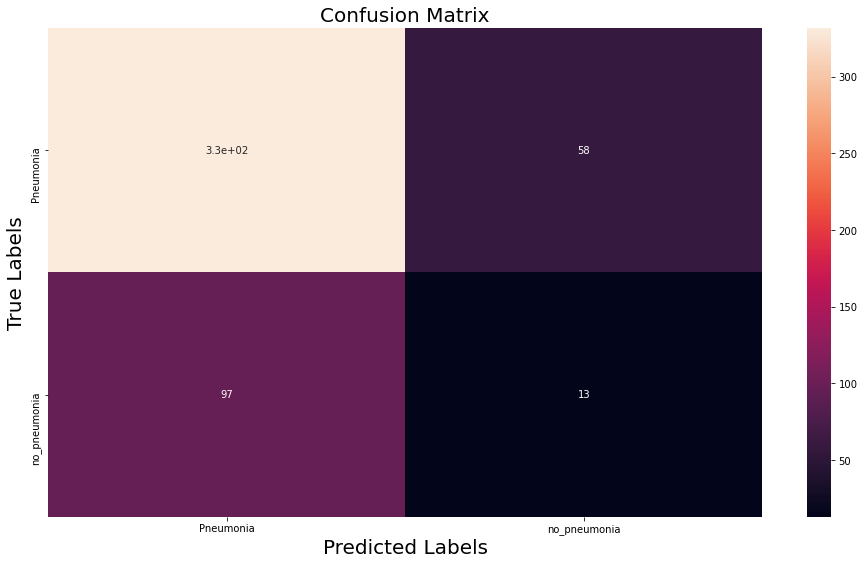

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns 
batch_size=64
Y_pred = inception_transfer.predict(test_generator,verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['NORMAL','PNEUMONIA']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

matrix = confusion_matrix(validation_generator.classes, y_pred)
labels=(( 'Pneumonia'),('no_pneumonia'))
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

(500, 224, 224, 3)
(500, 2)


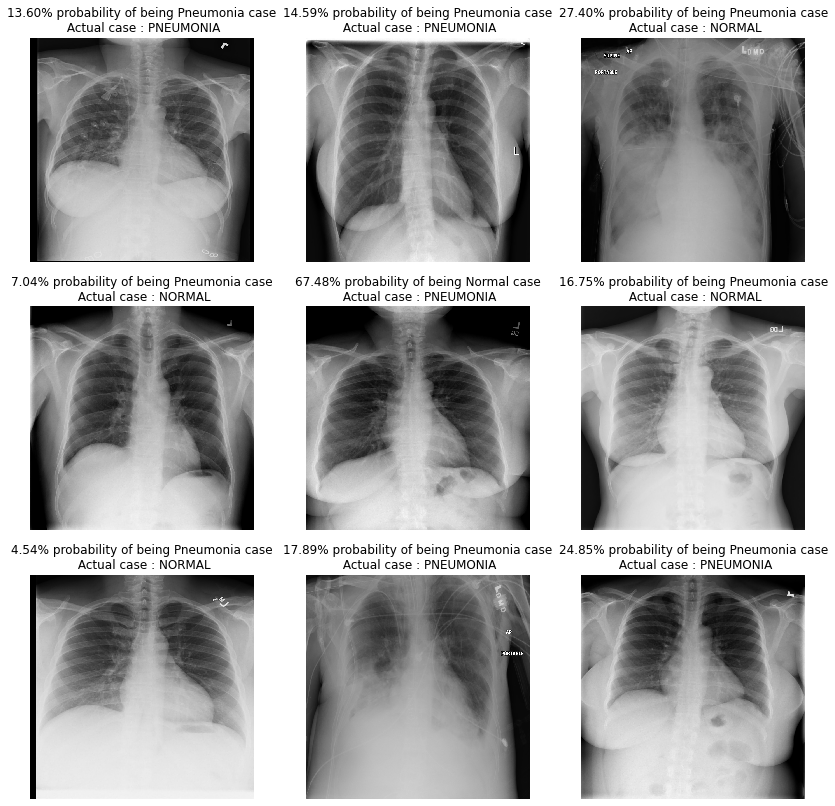

In [19]:
c